In [22]:
import pandas as pd
import json
import matplotlib.pyplot as plt
#from sklearnex import patch_sklearn
#patch_sklearn()

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

[nltk_data] Downloading package stopwords to /home/bruno/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


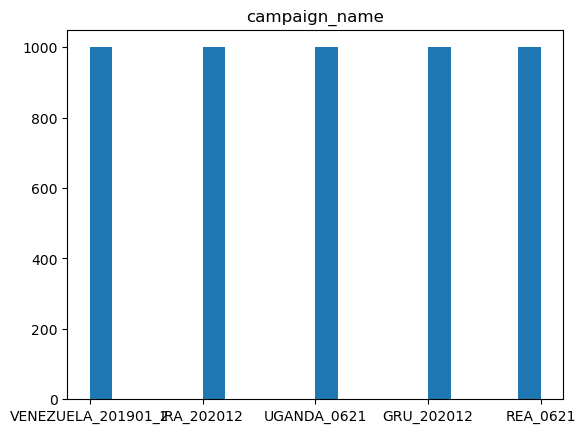

In [33]:
# Define a list of filenames to load
filenames = ["../data/labeled_data/generic_test_0.json"]

def load_and_concatenate_json(filenames):
    dfs = []
    df_train = []
    df_valid = []
    df_test = []
    for filename in filenames:
        with open(filename) as f:
            data = json.load(f)
        for key in ['train', 'test', 'valid']:
            df = pd.DataFrame(data[key])
            if key == "train":
                df_train = df
            elif key == "test":
                df_test = df
            elif key == "valid":
                df_valid = df
            dfs.append(df)
    return df_train, df_valid, df_test, pd.concat(dfs)

df_train, df_valid, df_test, df_all = load_and_concatenate_json(filenames)

# Generate exploratory data analysis on each column
plt.hist(df_all["campaign_name"], bins=20)
plt.title("campaign_name")
plt.show()

In [11]:
df_all

,id,campaign_name,text,annotations
0,891103871484870657,VENEZUELA_201901_2,How life may find a way on Saturn's moon https...,[Science/Technology]
1,898650367067664384,VENEZUELA_201901_2,RightWing Millennial Retweet RT RT_America to ...,[Others]
2,1012051694136512512,IRA_202012,The tobacco industry then peddles their produc...,"[Health, Justice/Crime, Macroeconomics/Economi..."
3,1296389394883063810,UGANDA_0621,"RT @brianmixologist: Today, i want to salute a...",[Others]
4,1286189347973279746,UGANDA_0621,RT @ArthurMirama: You can only under estimate ...,[Government/Public]
...,...,...,...,...
795,847754640972070912,VENEZUELA_201901_2,Stocks: 5 things to know before the bell https...,[Others]
796,1038043813267296256,GRU_202012,"September 4, 2018 #Syrian air defense units re...",[War/Terror]
797,1030464264748728320,UGANDA_0621,RT @xJ57jjSHWvX9mAMmhv7fVaVzxe13bBfCZuGZaBNucL...,[Others]
798,1020843977669586945,UGANDA_0621,RT @HowweEnt: Dj Shiru To Thrill His Fans http...,[Others]


In [12]:
df_all.head(10)

,id,campaign_name,text,annotations
0,891103871484870657,VENEZUELA_201901_2,How life may find a way on Saturn's moon https...,[Science/Technology]
1,898650367067664384,VENEZUELA_201901_2,RightWing Millennial Retweet RT RT_America to ...,[Others]
2,1012051694136512512,IRA_202012,The tobacco industry then peddles their produc...,"[Health, Justice/Crime, Macroeconomics/Economi..."
3,1296389394883063810,UGANDA_0621,"RT @brianmixologist: Today, i want to salute a...",[Others]
4,1286189347973279746,UGANDA_0621,RT @ArthurMirama: You can only under estimate ...,[Government/Public]
5,1125360943926476805,GRU_202012,HTS militants shelled Mharda from Ltamenah onc...,[War/Terror]
6,1127857811856216064,REA_0621,Mohlakeng petrol bombing: town councilor susta...,[War/Terror]
7,1245803388652183553,IRA_202012,González: \n • We tried to break the power of ...,[Government/Public]
8,1038830348455563265,GRU_202012,The National Intelligence Organization #Turkis...,[War/Terror]
9,1301007858327224320,IRA_202012,RT @telesurenglish: #Brazil | Supreme Court o...,[Justice/Crime]


In [13]:
df_all.sample(10, random_state=42).text.to_list()

['Apple is setting up shop in Samsung territory https://t.co/jMCDlkbj7z https://t.co/KlELv8NYHN',
 "RT @brintonmarcus: Don't be pushed around by  the fears in your mind. Be led by the dreams in your heart📌\nBlessed Sunday Fam ❤️",
 '@Masanga101 @TheOtheGuyHere @mkyewalabye @LocalManWolf @KampalaTraffic @MoWT_Uganda @uginm102 @TheMatundaMan @CQvMyyB0YfvwrUrsaZ6KI7yqaJfSUDTrAI0joQhgMA= @mkainerugaba @bruno_akampa @KalindaMwene damage was registered on the Airline’s assets which included looting and destruction of aircraft, aircraft spare parts, office and ground handling equipment. During the war, one B707 was damaged at Entebbe Airport and another was flown to Libya, while one Kingair was stolen and',
 'BEHNA: Liberal Twitter Users Upset Over Trump’s “Apprentice” Joke At National Prayer Breakfast https://t.co/ME47cHbLvp https://t.co/Z6j3rOjnyH',
 'RT @FafN4kfTzc8XmRFU23WgYc7LIFYiCfigO9dqljAsaQ=: Uganda is more than just gorillas &amp; chimps - venture north &amp; visit Kidepo Valley NP\

In [14]:
df_all.sample(10, random_state=42)

,id,campaign_name,text,annotations
1501,817308573478764544,VENEZUELA_201901_2,Apple is setting up shop in Samsung territory ...,[Others]
2586,1320275632299905024,UGANDA_0621,RT @brintonmarcus: Don't be pushed around by ...,[Others]
2653,1266443013947043846,UGANDA_0621,@Masanga101 @TheOtheGuyHere @mkyewalabye @Loca...,[Justice/Crime]
1055,827278100643749889,VENEZUELA_201901_2,BEHNA: Liberal Twitter Users Upset Over Trump’...,"[Education, Government/Public]"
705,1347545565551341579,UGANDA_0621,RT @FafN4kfTzc8XmRFU23WgYc7LIFYiCfigO9dqljAsaQ...,[Others]
106,1190314366509432839,GRU_202012,#Kurds throw vegetables at #Turkish armored ve...,[War/Terror]
589,1095618078849654784,IRA_202012,💼Afghanistan's president on Tuesday dismissed ...,"[Election Campaign, Government/Public]"
2468,1321427487914708996,UGANDA_0621,I can never tweet about sex 🙄,[Others]
2413,893273314168156160,VENEZUELA_201901_2,The FBI’s Entire Senior Staff Is Set To Testif...,"[Government/Public, Justice/Crime]"
1600,1047724314152370176,IRA_202012,🔔The financial squeeze on India's farmers is s...,"[Government/Public, Macroeconomics/Economic Re..."


In [15]:
df_all[df_all['annotations'].apply(lambda x: "War/Terror" in x)].sample(10, random_state=42).text.to_list()

['The Western coalition led by the #UnitedStates struck a blow at the village of Hoveibaria, where a temporary camp for refugees from Iraq was placed. As a result of the #attack, at least 18 people were killed #Syria #Khaseke https://t.co/4uSgIaGAMW',
 'Russian military aircraft Su-34 and Su-35 are on duty in the air in two areas in northern #Syria. American experts call the Su-35 "extremely dangerous" for any #NATO aircraft\n#AirForce https://t.co/laE8fUV1yo',
 'RT @Ben_Jonson_1985: During the #OliveBranchOperation in #Syria, 703 #Turkish soldiers were killed and 25 were captured by #Kurdish self-de…',
 'RT @DrBasselAbuward: Do u know that by not boycotting Israeli products,ur money goes to the same ppl who r killing #Gaza kids\n#ICC4Israel h…',
 'Hi guys!\nSorry for having been silent for a month.\nMy congratulations to all the Syrians - the north of Hama is free now and people may live there happily ever after!',
 "About seven thousand Syrians returned to their homes in the settleme

In [16]:
df_all[df_all['annotations'].apply(lambda x: "War/Terror" in x)].sample(10, random_state=42)

,id,campaign_name,text,annotations
2222,1006444868669976576,GRU_202012,The Western coalition led by the #UnitedStates...,"[Conspiracy Theory, Immigration/Integration, W..."
2611,1192326099285491712,GRU_202012,Russian military aircraft Su-34 and Su-35 are ...,[War/Terror]
2829,979256010534739969,GRU_202012,RT @Ben_Jonson_1985: During the #OliveBranchOp...,[War/Terror]
993,494298543478550528,IRA_202012,RT @DrBasselAbuward: Do u know that by not boy...,"[Justice/Crime, Macroeconomics/Economic Regula..."
256,1166334971101024257,GRU_202012,Hi guys!\nSorry for having been silent for a m...,"[War/Terror, Others]"
1174,1019618291927666688,GRU_202012,About seven thousand Syrians returned to their...,"[Immigration/Integration, War/Terror]"
9,1215543318714757121,GRU_202012,"""The General Command of the Armed Forces of #L...","[Government/Public, War/Terror]"
3080,1056937740225441792,GRU_202012,RT @9zxsi+qIsPp4ZaNFZCxaLJIePPypzDuzVZg97pJfU=...,[War/Terror]
474,1006542296970616833,GRU_202012,The #UnitedStates of #America has supplied the...,"[Conspiracy Theory, War/Terror]"
2854,983238335610150912,GRU_202012,RT @Ben_Jonson_1985: In the province of #Homs ...,"[Government/Public, War/Terror]"


In [17]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 799
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             5000 non-null   object
 1   campaign_name  5000 non-null   object
 2   text           5000 non-null   object
 3   annotations    5000 non-null   object
dtypes: object(4)
memory usage: 195.3+ KB


In [35]:
# Split the data into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(df_all["text"], df_all["annotations"], test_size=0.2, random_state=42)

# Calculate the class frequencies for the training and testing sets
freqs = df_all["annotations"].value_counts(normalize=True)

# Print the results
print("Class frequencies:")
print(freqs)

Class frequencies:
[Others]                                                          0.2622
[War/Terror]                                                      0.1380
[Government/Public]                                               0.1354
[Justice/Crime]                                                   0.0850
[Government/Public, War/Terror]                                   0.0236
                                                                   ...  
[Conspiracy Theory, Environment, War/Terror]                      0.0002
[Health, Macroeconomics/Economic Regulation, Media/Journalism]    0.0002
[Education, Science/Technology]                                   0.0002
[Government/Public, Immigration/Integration, Media/Journalism]    0.0002
[Environment, Health, Science/Technology]                         0.0002
Name: annotations, Length: 196, dtype: float64


In [36]:
# Count the number of rows with multiple annotations
multi_count = df_all[df_all["annotations"].apply(lambda x: len(x) > 1)].shape[0]

# Print the result
print(f"Number of rows with multiple annotations: {multi_count}")

Number of rows with multiple annotations: 1412


In [37]:
df_all

,id,campaign_name,text,annotations
0,891103871484870657,VENEZUELA_201901_2,How life may find a way on Saturn's moon https...,[Science/Technology]
1,898650367067664384,VENEZUELA_201901_2,RightWing Millennial Retweet RT RT_America to ...,[Others]
2,1012051694136512512,IRA_202012,The tobacco industry then peddles their produc...,"[Health, Justice/Crime, Macroeconomics/Economi..."
3,1296389394883063810,UGANDA_0621,"RT @brianmixologist: Today, i want to salute a...",[Others]
4,1286189347973279746,UGANDA_0621,RT @ArthurMirama: You can only under estimate ...,[Government/Public]
...,...,...,...,...
795,847754640972070912,VENEZUELA_201901_2,Stocks: 5 things to know before the bell https...,[Others]
796,1038043813267296256,GRU_202012,"September 4, 2018 #Syrian air defense units re...",[War/Terror]
797,1030464264748728320,UGANDA_0621,RT @xJ57jjSHWvX9mAMmhv7fVaVzxe13bBfCZuGZaBNucL...,[Others]
798,1020843977669586945,UGANDA_0621,RT @HowweEnt: Dj Shiru To Thrill His Fans http...,[Others]


In [38]:
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer('english')

def preprocess_text(text):
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = text.lower()
    #text = [stemmer.stem(word) for word in text.split() if word not in stop_words]
    #text = ' '.join(text)
    return text

df_train['text_processed'] = df_train['text'].apply(preprocess_text)
df_test['text_processed'] = df_test['text'].apply(preprocess_text)
df_valid['text_processed'] = df_valid['text'].apply(preprocess_text)
df_train.head()

,id,campaign_name,text,annotations,text_processed
0,891103871484870657,VENEZUELA_201901_2,How life may find a way on Saturn's moon https...,[Science/Technology],how life may find a way on saturn s moon https...
1,898650367067664384,VENEZUELA_201901_2,RightWing Millennial Retweet RT RT_America to ...,[Others],rightwing millennial retweet rt rt america to ...
2,1012051694136512512,IRA_202012,The tobacco industry then peddles their produc...,"[Health, Justice/Crime, Macroeconomics/Economi...",the tobacco industry then peddles their produc...
3,1296389394883063810,UGANDA_0621,"RT @brianmixologist: Today, i want to salute a...",[Others],rt brianmixologist today i want to salute a...
4,1286189347973279746,UGANDA_0621,RT @ArthurMirama: You can only under estimate ...,[Government/Public],rt arthurmirama you can only under estimate ...


In [40]:
mlb = MultiLabelBinarizer()
y_train = mlb.fit_transform(df_train['annotations'])
X_train = df_train["text_processed"]

y_test = mlb.fit_transform(df_test["annotations"])
X_test = df_test["text_processed"]
#X_train, X_test, y_train, y_test = train_test_split(df_all['text_processed'], y, test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)
clf = OneVsRestClassifier(LinearSVC())
clf.fit(X_train_tfidf, y_train)

y_pred = clf.predict(X_test_tfidf)
print('macro F1 score:', f1_score(y_test, y_pred, average='macro'))
print('macro Precision:', precision_score(y_test, y_pred, average='macro'))
print('macro Recall:', recall_score(y_test, y_pred, average='macro'))
print('micro F1 score:', f1_score(y_test, y_pred, average='micro'))
print('micro Precision:', precision_score(y_test, y_pred, average='micro'))
print('micro Recall:', recall_score(y_test, y_pred, average='micro'))

macro F1 score: 0.3914945823478114
macro Precision: 0.6939667521182284
macro Recall: 0.30005600303977925
micro F1 score: 0.6578574799433695
micro Precision: 0.8520782396088019
micro Recall: 0.5357417371252883


/home/bruno/anaconda3/envs/p5/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [47]:
report = classification_report(y_test, y_pred, target_names=mlb.classes_, output_dict=True)
report

/home/bruno/anaconda3/envs/p5/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bruno/anaconda3/envs/p5/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'Conspiracy Theory': {'precision': 0.6153846153846154,
  'recall': 0.17777777777777778,
  'f1-score': 0.27586206896551724,
  'support': 45},
 'Education': {'precision': 1.0,
  'recall': 0.07692307692307693,
  'f1-score': 0.14285714285714288,
  'support': 13},
 'Election Campaign': {'precision': 0.9285714285714286,
  'recall': 0.3939393939393939,
  'f1-score': 0.5531914893617021,
  'support': 33},
 'Environment': {'precision': 0.0,
  'recall': 0.0,
  'f1-score': 0.0,
  'support': 14},
 'Government/Public': {'precision': 0.7394957983193278,
  'recall': 0.6048109965635738,
  'f1-score': 0.665406427221172,
  'support': 291},
 'Health': {'precision': 0.8888888888888888,
  'recall': 0.34782608695652173,
  'f1-score': 0.5,
  'support': 46},
 'Immigration/Integration': {'precision': 1.0,
  'recall': 0.3333333333333333,
  'f1-score': 0.5,
  'support': 36},
 'Justice/Crime': {'precision': 0.9390243902439024,
  'recall': 0.5620437956204379,
  'f1-score': 0.7031963470319634,
  'support': 137},
 '

In [42]:
report_df = pd.DataFrame(report).transpose()
def calculate_fbeta_score(beta, precision, recall):
    return (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall)

avg_f1_score = report_df.loc['macro avg', 'f1-score']
avg_accuracy = 0  # Not defined in the multilabel case
avg_fbeta_score = calculate_fbeta_score(0.5, report_df.loc['macro avg', 'precision'], report_df.loc['macro avg', 'recall'])
print(avg_f1_score, avg_accuracy, avg_fbeta_score)

0.3914945823478114 0 0.5496513176235829


In [46]:
from sklearn.metrics import precision_recall_fscore_support
# Compute precision, recall, F1-score, and support
precision, recall, f1_score, support = precision_recall_fscore_support(y_pred, y_test)

# Create a dictionary with class names as keys and support values as values
class_support = dict(zip(mlb.classes_, support))

# Print the support values for each class
for class_name, support_value in class_support.items():
    print(f"{class_name}: {support_value}")

Conspiracy Theory: 13
Education: 1
Election Campaign: 14
Environment: 0
Government/Public: 238
Health: 18
Immigration/Integration: 12
Justice/Crime: 82
Labor/Employment: 3
Macroeconomics/Economic Regulation: 19
Media/Journalism: 14
Others: 187
Religion: 1
Science/Technology: 0
War/Terror: 216


/home/bruno/anaconda3/envs/p5/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [44]:
from tabulate import tabulate

table = []
headers = ["Label", "F1 Score", "Precision", "Recall"]
for label in mlb.classes_:
    row = [label, report[label]["f1-score"], report[label]["precision"], report[label]["recall"]]
    table.append(row)

print(tabulate(table, headers=headers, tablefmt="pipe"))

| Label                              |   F1 Score |   Precision |    Recall |
|:-----------------------------------|-----------:|------------:|----------:|
| Conspiracy Theory                  |   0.275862 |    0.615385 | 0.177778  |
| Education                          |   0.142857 |    1        | 0.0769231 |
| Election Campaign                  |   0.553191 |    0.928571 | 0.393939  |
| Environment                        |   0        |    0        | 0         |
| Government/Public                  |   0.665406 |    0.739496 | 0.604811  |
| Health                             |   0.5      |    0.888889 | 0.347826  |
| Immigration/Integration            |   0.5      |    1        | 0.333333  |
| Justice/Crime                      |   0.703196 |    0.939024 | 0.562044  |
| Labor/Employment                   |   0.129032 |    0.666667 | 0.0714286 |
| Macroeconomics/Economic Regulation |   0.395062 |    0.842105 | 0.258065  |
| Media/Journalism                   |   0.451613 |    1        

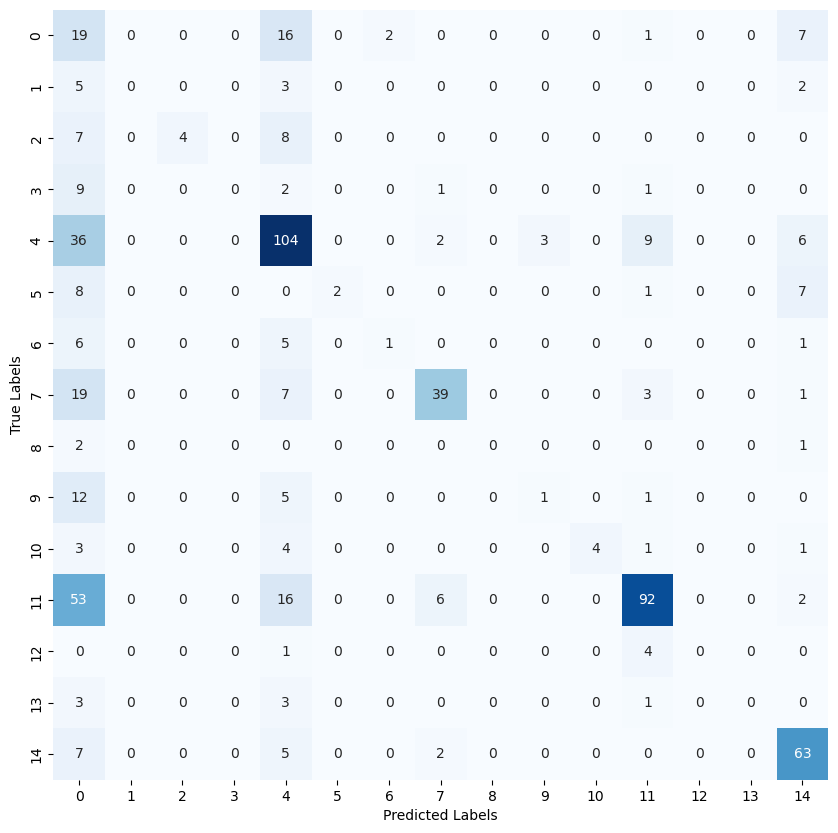

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the confusion matrix
cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

# Plot the confusion matrix using seaborn
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [12]:
df_all.iloc[0].annotations

['Science/Technology']

In [13]:
df_all.iloc[0].text_processed

'how life may find a way on saturn s moon https   t co acambg yam https   t co  jst itnvh'

In [14]:
new_text = ['how life may find a way on saturn s moon https   t co acambg yam https   t co  jst itnvh']
new_text_tfidf = vectorizer.transform(new_text)
new_y_pred = clf.predict(new_text_tfidf)
new_labels = mlb.inverse_transform(new_y_pred)
print(new_labels)

[()]
